In [33]:
import pandas as pd
import numpy as np
import re
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Embedding,Input,LSTM,Dense, Dropout
from keras.layers.core import Lambda
from keras.layers.merge import concatenate, add, multiply
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
# from fuzzywuzzy import fuzz
# import distance


In [8]:
import nltk
nltk.download('stopwords')
DATA_PATH = "./"
WNL = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

MAX_SENT_LEN = 30
CUT_SENT_LEN = 8
EMBEDDING_DIM = 300

REPLACE_WORD = "ttitto"
LAPLACE_ADD = 1e-5
NUM_OF_FEATURES = 10
NUM_K_FOLDS = 1

BATCH_SIZE = 256
N_EPOCHS = 10

[nltk_data] Downloading package stopwords to /Users/hdong/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##  0. Present data distribution

In [45]:
train_df = pd.read_csv(DATA_PATH+"train.csv", sep=',')
test_df = pd.read_csv(DATA_PATH+"test.csv", sep=',')

In [46]:
%matplotlib inline
sns.set_style("dark")

def plot_real_feature(fname):
    ix_train = train_df['id']
    ix_is_dup = np.where(train_df['is_duplicate'] == 1)[0]
    ix_not_dup = np.where(train_df['is_duplicate'] == 0)[0]
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(train_df.loc[ix_train][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(train_df.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='is dup')    
    sns.distplot(train_df.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not dup')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='is_duplicate', 
                data=train_df.loc[ix_train], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='is_duplicate', 
                   data=train_df.loc[ix_train], 
                   ax=ax4)
    plt.show()
    

### a. Absolute value of difference between q1 length and q2 length

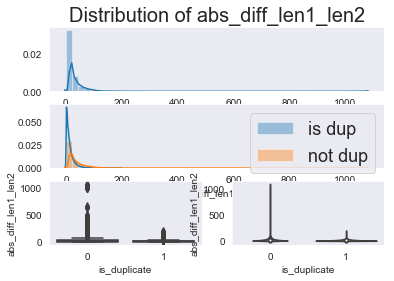

In [47]:
train_df['q1_len'] = train_df['question1'].str.len().astype(np.float32)
train_df['q2_len'] = train_df['question2'].str.len().astype(np.float32)
train_df['abs_diff_len1_len2'] = np.abs(train_df['q1_len'] - train_df['q2_len'])
plot_real_feature('abs_diff_len1_len2')

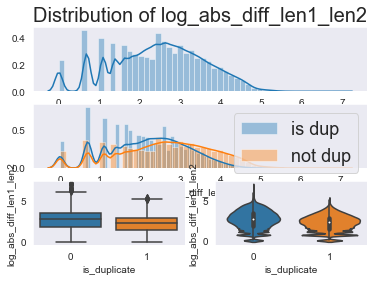

In [48]:
train_df['log_abs_diff_len1_len2'] = np.log(train_df['abs_diff_len1_len2'] + 1)
plot_real_feature('log_abs_diff_len1_len2')

### b. Ratio of  q1 length to q2 length

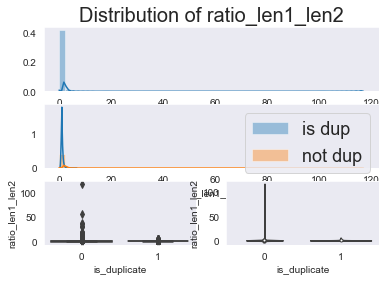

In [49]:
train_df['ratio_len1_len2'] = train_df['q1_len'].apply(lambda x: x if x > 0.0 else 1.0)/\
                        train_df['q2_len'].apply(lambda x: x if x > 0.0 else 1.0)
plot_real_feature('ratio_len1_len2')

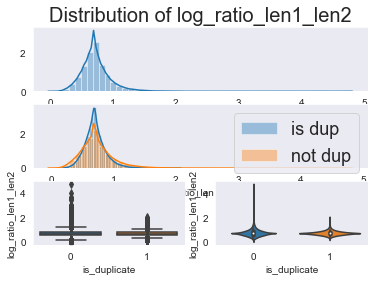

In [43]:
train_df['log_ratio_len1_len2'] = np.log(train_df['ratio_len1_len2'] + 1)
plot_real_feature('log_ratio_len1_len2')

## I. Preprocess Data and Extract Features

### a. Clear Data

In [3]:
def clear_string(string):
    string = string.lower() \
        .replace("won't", "will not").replace("'ll", " will").replace("cannot", "can not").replace("can't", "can not") \
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
        .replace("'ve", " have").replace("'d", " would").replace("i'm", "i am").replace("'re", " are") \
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ").replace("€", " euro ") \
        .replace(",000,000", "m").replace(",000", "k")\
        .replace("=", " equal ").replace("+", " plus ").replace("&", "and").replace("|", "or")\
        .replace("′", "'").replace("’", "'")\
        .replace("e mail", "email").replace("e - mail", "email").replace("e-mail", " email")\
        .replace(" quikly ", " quickly ").replace(" unseccessful ", " unsuccessful ").replace(" insititute ", " institute ")\
        .replace(" programmning ", " programming ").replace(" litrate ", " literate ").replace(" intially ", " initially ")\
        .replace(" demonitization ", " demonetization ").replace(" actived ", " active ").replace(" begineer ", " beginner ")\
        .replace(" connectionn ", " connection ").replace(" permantley ", " permanently ").replace(" litrate ", " literate ")
    string = re.sub('[“”\(\'…\)\!\^\"\.;:,\-\?？\{\}\[\]\\/\*@]', ' ', string)
    return string


#  preliminarily clear data for extracting features
def preprocess_df1(df):
    df['question1'] = df['question1'].apply(lambda x : clear_string(str(x)))
    df['question2'] = df['question2'].apply(lambda x : clear_string(str(x)))

    # discard length less than CUT_SENT_LEN characters
    df['q1_len'] = df.question1.apply(lambda x : len(x))
    df['q2_len'] = df.question2.apply(lambda x : len(x))

    indices = set(df[df['q1_len']<CUT_SENT_LEN].index).union(df[df['q2_len']<CUT_SENT_LEN].index)
    df.drop(indices, inplace=True)
    df.reset_index()
    
    # Can drop the character count columns - to save memory
    df.drop(['q1_len','q2_len'], inplace=True, axis=1)
    return df

In [4]:
train_df = preprocess_df1(train_df)
test_df = preprocess_df1(test_df)
print("preprocess_df1 finished")

preprocess_df1 finished


### b. Extract Features

In [50]:
def get_features(q1, q2):
    features = {}

    q1_words = q1.split()
    q2_words = q2.split()

    if len(q1_words) == 0 or len(q2_words) == 0:
        return features

    q1_stops = set([word for word in q1_words if word in STOP_WORDS])
    q2_stops = set([word for word in q2_words if word in STOP_WORDS])

    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_word_count = len(set(q1_words).intersection(set(q2_words)))

    features["common_stop_ratio_min"] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + LAPLACE_ADD)
    features["common_stop_ratio_max"] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + LAPLACE_ADD)
    features["common_ratio_min"] = common_word_count / (min(len(q1_words), len(q2_words)) + LAPLACE_ADD)
    features["common_ratio_max"] = common_word_count / (max(len(q1_words), len(q2_words)) + LAPLACE_ADD)
    features["is_last_word_equal"] = int(q1_words[-1] == q2_words[-1])
    features["is_fisrt_word_equal"] = int(q1_words[0] == q2_words[0])
    features["len_diff"] = abs(len(q1_words) - len(q2_words))
    features["avg_length"] = (len(q1_words) + len(q2_words))/2
    
    features["fuzzy_common_ratio"] = fuzz.QRatio(q1, q2)
    features["fuzzy_set_common_ratio"] = fuzz.token_set_ratio(q1, q2)
    features["fuzzy_sort_common_ratio"] = fuzz.token_set_ratio(q1, q2)
    features["fuzzy_partial_common_ratio"] = fuzz.partial_ratio(q1, q2)
    
    NUM_OF_FEATURES = len(features.keys())
    return features

def extract_features(df):
    print("Calculating... (this may take up to several hours)")
    features = df.apply(lambda x: get_features(x["question1"], x["question2"]), axis=1)
    
    for feature in features[0].keys():
        f = str(feature)
        df[f] = [line[f] for line in features]
        print("Finished extracting " + f)
    return df

def generate_features(df, name):
    df = extract_features(df)
    dfs = np.split(df, [6], axis=1)
    dfs[1].to_csv(DATA_PATH + name, index=False) 
    df = dfs[0]

In [51]:
import os
if not os.path.isfile(DATA_PATH + "features_train.csv"):
    print("------------Extracting features in training set---------------")
    generate_features(train_df, "features_train.csv")
    print(str(NUM_OF_FEATURES) + " features have been extracted and saved to features_train.csv")

if not os.path.isfile(DATA_PATH + "features_test.csv"):
    df = test_df
    print("------------Extracting features in test set---------------")
    generate_features(test_df, "features_test.csv")

------------Extracting features in training set---------------
Calculating... (this may take up to several hours)


NameError: ("name 'fuzz' is not defined", 'occurred at index 0')

### c. Embedding Init based on glove

In [ ]:
def read_glove_embedding(file_name, embedding_dim):
    embeddings_index = {}
    f = open(file_name, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
#         if len(values) == embedding_dim + 1 and word in top_words:
        if len(values) == embedding_dim + 1:
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    f.close()
    return embeddings_index

In [ ]:
embeddings = read_glove_embedding(DATA_PATH+"glove.840B.300d.txt", EMBEDDING_DIM)

In [ ]:
top_words = embeddings.keys()

### d. Lemmatization and Process Scarce Words

In [ ]:
# lemmatization 词形还原
def cutter_and_replace(word):
    if len(word) >= 4:
        word = WNL.lemmatize(WNL.lemmatize(word, "n"), "v")
    if word in top_words:
        return word
    elif word not in STOP_WORDS:
        return REPLACE_WORD
    return ""

def preprocess_string(string):
    string = ' '.join([cutter_and_replace(w) for w in string.split()])
    return string

# process data
def preprocess_df2(df):
    df['question1'] = df['question1'].apply(lambda x : preprocess_string(str(x)))
    df['question2'] = df['question2'].apply(lambda x : preprocess_string(str(x)))
    return df

In [ ]:
train_df = preprocess_df2(train_df)
test_df = preprocess_df2(test_df)
print("preprocess_df2 finished")

### e. Tokenize

In [ ]:
tokenizer = Tokenizer()
# tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(np.append(train_df['question1'],train_df['question2']))
word_index = tokenizer.word_index
print("tokenizer initialization finished")

In [ ]:
def tokenize_data(df, tokenizer):
    q1 = pad_sequences(tokenizer.texts_to_sequences(df['question1']), maxlen=MAX_SENT_LEN)
    q2 = pad_sequences(tokenizer.texts_to_sequences(df['question2']), maxlen=MAX_SENT_LEN)
    return q1, q2

In [ ]:
train_q1, train_q2 = tokenize_data(train_df, tokenizer)
train_labels = np.array(train_df.is_duplicate)

test_q1, test_q2 = tokenize_data(test_df, tokenizer)
print("tokenize data and get train data labels finished")

### f. Create an Embedding Matrix

In [ ]:
# Create an embedding matrix containing only the words in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

## III. Model

In [ ]:
train_features = pd.read_csv(DATA_PATH + "features_train.csv", encoding ='latin1')
# test_features =  pd.read_csv(DATA_PATH + "features_test.csv", encoding ='latin1')

In [ ]:
def get_questions_model():
    embedding_layer = Embedding(input_dim=len(word_index)+1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings_matrix],
                            input_length=MAX_SENT_LEN,
                            trainable=False,
                            mask_zero=False,
                            name='embedding_layer')
    lstm_layer = LSTM(75, recurrent_dropout=0.2)
    question_input_1 = Input(shape=(MAX_SENT_LEN,), dtype="int32")
    embedded_1 = embedding_layer(question_input_1)
    lstm_1 = lstm_layer(embedded_1)

    question_input_2 = Input(shape=(MAX_SENT_LEN,), dtype="int32")
    embedded_2 = embedding_layer(question_input_2)
    lstm_2 = lstm_layer(embedded_2)
    return question_input_1, question_input_2, lstm_1, lstm_2
    
def get_features_model():
    features_input = Input(shape=(train_features.shape[1],), dtype="float32")
    features_dense = BatchNormalization()(features_input)
    features_dense = Dense(200, activation="relu")(features_dense)
    features_dense = Dropout(0.2)(features_dense)
    return features_input, features_dense

def merge_models(lstm_q1, lstm_q2, features_dense):
    addition= add([lstm_q1, lstm_q2])
    minus_lstm_q2 = Lambda(lambda x: -x)(lstm_q2)
    merged = add([lstm_q2, minus_lstm_q2])
    merged = multiply([merged, merged])
    merged = concatenate([merged, addition])
    merged = Dropout(0.4)(merged)
    
    merged = concatenate([merged, features_dense])
    merged = BatchNormalization()(merged)
    merged = GaussianNoise(0.1)(merged)
    
    merged = Dense(150, activation="relu")(merged)
    merged = Dropout(0.2)(merged)
    merged = BatchNormalization()(merged)
    
    output_layer = Dense(1, activation="sigmoid")(merged)
    return output_layer

def get_model():
    q1_input, q2_input, lstm_q1, lstm_q2 = get_questions_model()
    features_input, features_dense = get_features_model()
    output_layer = merge_models(lstm_q1, lstm_q2, features_dense)
    
    model = Model(inputs=[q1_input, q2_input, features_input], outputs=output_layer)
    return model

In [ ]:
def predict(model):
    # predict and save the results
    preds = model.predict([test_q1, test_q2, test_features], batch_size=BATCH_SIZE, verbose=1)

    submission = pd.DataFrame({"test_id": test_df["test_id"], "is_duplicate": preds.ravel()})
    submission.to_csv("predictions/preds" + str(model_num) + ".csv", index=False)

In [ ]:
# skf = StratifiedKFold(n_splits=NUM_K_FOLDS, shuffle=True)
# model_num = 0
# # Stratified k-fold to split train data and val data for Cross-validation
# for train_id, val_id in skf.split(train_q1, train_labels):
#     print("MODEL:", model_num)
    
#     train_data_q1 = train_q1[train_id]
#     train_data_q2 = train_q2[train_id]
#     train_data_labels = train_labels[train_id]
#     train_data_features = train_features.values[train_id]
    
#     val_data_q1 = train_q1[val_id]
#     val_data_q2 = train_q2[val_id]
#     val_data_labels = train_labels[val_id]
#     val_data_features = train_features.values[val_id]
    
#     # get the model
#     model = get_model()
#     model.compile(loss='binary_crossentropy',
#                   optimizer='nadam')
    
#     # callbacks
#     early_stopping = EarlyStopping(monitor="val_loss", patience=5)
#     best_model_path = "best_model"+str(model_num) +".h5"
#     model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)
    
#     # fit the model
#     fit_result = model.fit(x = [train_data_q1, train_data_q2, train_data_features], 
#                            y = train_data_labels,
#                            validation_data = ([val_data_q1, val_data_q2, val_data_features], val_data_labels),
#                            batch_size=BATCH_SIZE, 
#                            epochs=N_EPOCHS, 
#                            callbacks=[early_stopping, model_checkpoint]
#                           )
#     model.load_weights(best_model_path)
#     print(model_count, "validation loss:", min(hist.history["val_loss"]))

# #     predict(model)

#     model_num += 1

In [ ]:
X_train_q1, X_val_q1, X_train_q2, X_val_q2, y_train, y_val, X_train_features, X_val_features =  train_test_split(train_q1,
                                                                                train_q2,
                                                                                train_labels,
                                                                               train_features,
                                                                                random_state=10, 
                                                                                test_size=0.1)
model = get_model()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


fit_result = model.fit(x = [X_train_q1, X_train_q2, X_train_features], 
          y = y_train, 
          batch_size=BATCH_SIZE, 
          epochs=N_EPOCHS, 
          validation_data=([X_val_q1, X_val_q2, X_val_features], y_val))


In [103]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 30, 300)      16141800    input_30[0][0]                   
                                                                 input_31[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 75)           112800      embedding_layer[0][0]            
                                                                 embedding_layer[1][0]            
__________________________________________________________________________________________________
input_30 (

## IV. Result Presentation

In [ ]:

def plot_result(r, title, figname):
    fig, ax1 = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(8)

    data1=r.history["acc"]
    data2=r.history["val_acc"]
    data1l=r.history["loss"]
    data2l=r.history["val_loss"]

    color = "r"
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.plot(data1, c=color, label="Train Accuracy")
    ax1.plot(data2, '--', c=color, label="Validation Accuracy")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc=0)

    color2 = "b"
    ax2 = ax1.twinx()  
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.plot(data1l, c=color2, label="Train Loss")
    ax2.plot(data2l, '--', c=color2, label="Validation Loss")
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.legend(loc=1)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.savefig(figname, format="pdf")
    plt.show()

In [ ]:
plot_result(fit_result, "Result on training set", "First.pdf")